# TPU setting

In [1]:
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [2]:
strategy = tf.distribute.TPUStrategy(resolver)

# 1. self-attention

`-` RNN은 이전 시각에 계산한 결과를 이용하여 순서대로 출력한다.

` -`  따라서 RNN의 계산을 시간 방향으로 병렬  계산하기란 기본적으로 불가능하다.

`-` 이 점은 딥러닝 학습이 GPU를 사용한 병렬  계산환경에서 이뤄진다는 점을 생각하면 큰 병목이 아닐 수 없음..

`-` `Attention is all you need` 라는 논문에서는 RNN을 사용하지 않는 대표적인 연구임 (나중에 꼭 읽어보자)

## 구조

`-` 쉽게 풀어보자면 Query, key, value라는 변수를 설정 후 학습하는 것이다.

`-` step1. Query, key, value

<center><img src="https://blog.kakaocdn.net/dn/VIoFm/btrTBJi1fIw/rv8FoLiFSaifvGR7uLMNi1/img.png"  width = 300></center>

* 3가지 변수의 초기 시작 값은 동일하다. 그러나 위의 학습과정을 통해 최종 값은 달라진다.

`-` step 2. Attention Layer

* 주어진 text가 "I am a student"이고 "i"라는 단어에 대한 $Q, K, V$

<center><img src="https://blog.kakaocdn.net/dn/ONq3A/btrTA6Tyae8/Qvk4WUckcas3PXDiBg1zg0/img.png" width = 400></center>


$$\text{Attention}(Q,K,V) = \text{softmax}\left (\frac {QK^{\top}}{\sqrt{d_k}}V \right )= \frac {3}{2} = 1.5$$

`-` step3. 이를 모든 단어에 대해 수행하면?

<center><img src = "https://blog.kakaocdn.net/dn/yt8W5/btrTzCenX8v/n1gjS3MTuhktj0xDDsox20/img.png", width = 500></center>

## 중간 정리

`1` 기존의 RNN 모델을 은닉노두 $h_t$가 이전 시점의 결과를 순차적으로 학습하였음

`2`  이는 연산 효율이 떨어지는 병목현상을 유발함

`3` attention 매커니즘은 주목해야할 정보에만 집중(softmax)하면서 모델의 성능 향상을 야기함.

`4` 그 중, `self-attettion`은 자기 자신에게 Attention 매커니즘을 행하는 방식임

  * 이를 하는 이유는 단어들의 연관성을 파악하기 위함

# 2. Multihead-Attention

<center><img src = "https://blog.kakaocdn.net/dn/cx6fS9/btrTFmhGL1b/liEpkqd2KPl2qwvXHPPYD0/img.png" width  = 500> </center>

<center><img src = "https://blog.kakaocdn.net/dn/cyB5SH/btrTDmwgt1P/ydDiUHQjW39fUD07xYMrD1/img.png" width = 300> </center>

`1` 팀 프로젝트가 더 효과적인 결정적인 이유는 다른 사람과 생각을 공유한다는 점이다.

`2` 다른 사람들과 생각을 공유하다 보면 내가 놓쳤거나 미처 생각하지 못한 부분을 발견할 수 있고 때로는 해야 하는 일의 양이 줄어들어 더욱 효율적으로 프로젝트를 진행할 수 있습니다.

`3` 이러한 아이디어를 Attention 메커니즘에 적용한 사례가 바로 "Multihead Attention" 메커니즘이다.

`4` 그림에서 볼 수 있듰이 `num_head`수만큼 `Attention`을 각각 병렬로 나누어 계산한다.

`5` 그 후, 도출된  Attention Value들을 마지막에 `concatenate`를 통해 하나로 합침

## 비교

* 일반적인 Attention 메커니즘

<center><img src = "https://blog.kakaocdn.net/dn/cgI7XL/btrTHPRvyVx/dukzxTN7p8zS1tKokwZ23k/img.png" width = 500></center>

* Multi-head Attention 메커니즘

<center><img src= "https://blog.kakaocdn.net/dn/PrYWZ/btrTGZz0eAH/KhrIxmbrDlU8CueeztcEJK/img.png" width = 500 ></center>

* 자! 멀티헤드 어텐션을 이용하면 기존의 `4 x 8` 이었던 $Q, K, V$를 4등분하여 병렬처리 하는 것을 볼 수 있다!!

* 앞서 설명했듯이 사람들이 회의를 하듯이 여러 부분에서 도출된 결과를 통해 서로 정보를 상호보완하여 더 좋은 성능을 야기할 수 있다!

***

# 3. Positional Encoding

`-` 앞선 단계들의 문제점은 문장을 한번에 병렬 처리 했기 떄문에 **단어간 순서가 반영되지 않았다는 것이다.**

`-` 따라서 아래와 같이 embedding 벡터에 각 단어들의 `position embedding`을 더해주자.

<center><img src = "https://blog.kakaocdn.net/dn/bTRJGq/btrTWNr7cwq/FqefWFksQtR2ncKcvieokk/img.png" width = 500></center>

## positional embedding의 조건

`1` 모델의 효율적인 학습을 위해 스케일이 어느 정도 범위 안에 있어야 한다.

* 만약, positional embedding의 스케일 범위가 너무 크면 이 자체 값의 영향력이 너무 커져 다른 값이 무시되어 학습되지 않음,.

`2` input data의 크기에 상관없이 output을 도출해야된다.

* 만약, input data의 크기가 10일 때에 대해서만 output을 도출할 수 있다면, 다른 사이즈의 input data에 대해서는 output을 도출할 수 없다..

* 위 조건을 모두 만족하는 함수가 삼각함수인데  주기적으로 반복돼서 정보가 겹친다는 점을 해결하위해 임베딩 차원이 짝수, 홀수에 따라 다음과 같이 정의한다.

$$PE_{pos, 2i} =  \text{sin}\left(\frac {pos}{10000^{2i/d_{model}}}\right )$$

$$PE_{pos, 2i+1} =  \text{cos}\left(\frac {pos}{10000^{2i/d_{model}}}\right )$$

# Transformer

`-` 그래서 Transformer가 뭐냐?

* 위 처럼 RNN의 문제점을 해결한 Attention 메커니즘으로만 이루어진 encoder-decoder 구조의 모델이다.

* 또한, 병렬처리를 할 떄 단어의 순서 정보를 기록하기위해 Positional Encoding 방법을 사용한다.

* 이를 도식화하면

<center><img src = "https://blog.kakaocdn.net/dn/z84El/btrTy4IOk9s/0qN9z3EPxX9bNoGsULLXuK/img.png" width = 400></center>

## 실습. imdb 데이터

### (1) 데이터 로드 및 전처리

In [6]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

17464789/17464789 [==============================] - 0s 0us/step


In [8]:
max_len = 500
vocab_size = len(set([j for i in x_train for j in i]))

`-` 패딩

In [9]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen = 500)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen = 500)

### (2) 멀티 헤드 엍켄션 클래스 구현

`-` `num_heads` = 8로 설정

In [11]:
# | code-fold : true
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

### (3) 인코더 설계

`-` 멀티 헤드 어텐션에 두 번쨰 서브층, 포지션 와이즈 피드 포워드 신경망을 추가하여 인코더 클래스를 설계

In [12]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm


### (4) 포지션 임베딩 설계

In [13]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### (5) 모델링

In [26]:
embedding_dim = 120  # 각 단어의 임베딩 벡터의 차원
num_heads = 8  # 어텐션 헤드의 수
dff = 120  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

with strategy.scope() :
          inputs = tf.keras.layers.Input(shape=(max_len,))
          embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
          x = embedding_layer(inputs)
          transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
          x = transformer_block(x)
          x = tf.keras.layers.GlobalAveragePooling1D()(x)
          x = tf.keras.layers.Dropout(0.1)(x)
          x = tf.keras.layers.Dense(20, activation="relu")(x)
          x = tf.keras.layers.Dropout(0.1)(x)
          outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

          model = tf.keras.Model(inputs=inputs, outputs=outputs)
          model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                                      loss = tf.keras.losses.binary_crossentropy)

### (6) 모델 학습

In [27]:
h = model.fit(x_train, y_train, epochs = 10,
                          validation_split = 0.2).history

Epoch 1/10
625/625 [==============================] - 23s 23ms/step - loss: 0.6950 - val_loss: 0.6932
Epoch 2/10
625/625 [==============================] - 12s 19ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/10
625/625 [==============================] - 12s 19ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/10
625/625 [==============================] - 12s 19ms/step - loss: 0.4739 - val_loss: 0.2822
Epoch 5/10
625/625 [==============================] - 12s 19ms/step - loss: 0.1884 - val_loss: 0.2648
Epoch 6/10
625/625 [==============================] - 12s 19ms/step - loss: 0.0955 - val_loss: 0.3670
Epoch 7/10
625/625 [==============================] - 12s 19ms/step - loss: 0.0428 - val_loss: 0.5349
Epoch 8/10
625/625 [==============================] - 12s 19ms/step - loss: 0.0252 - val_loss: 0.6099
Epoch 9/10
625/625 [==============================] - 12s 20ms/step - loss: 0.0134 - val_loss: 0.6918
Epoch 10/10
625/625 [==============================] - 12s 19ms/step - loss: 0.010

In [28]:
import matplotlib.pyplot as plt

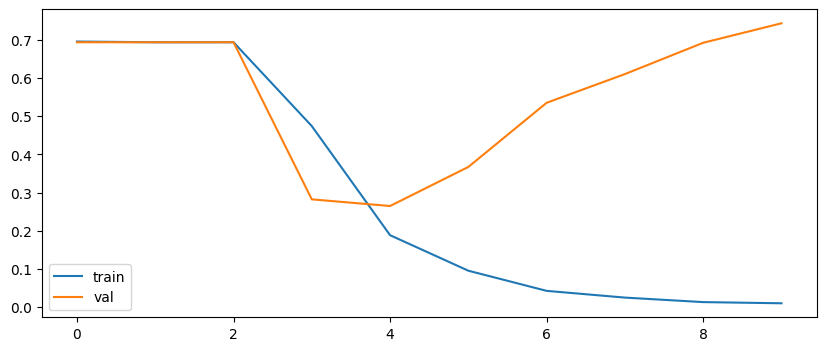

In [29]:
plt.figure(figsize = (10,4))
plt.plot(h["loss"], label = "train")
plt.plot(h["val_loss"], label = "val")
plt.legend()
plt.show()

### (7) 예측

In [30]:
import numpy as np
from sklearn.metrics import *

In [31]:
pred = model.predict(x_test)
y_pred = np.where(pred>=0.5, 1, 0)

782/782 [==============================] - 8s 10ms/step


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86     12500
           1       0.86      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



`-` 방금전 LSTM으로 0.82의 test 정확도가 나왔는데...

`-` 오, 0.04이나 개선되었다!

## ref

1. [ratsgo's NLPBOOK](https://ratsgo.github.io/nlpbook/) : Copyright © 2020 Gichang LEE.

2. [코딩 오페라](https://codingopera.tistory.com/43)

3. [딥러닝을 이용한 자연어 처리 입문](https://wikidocs.net/103802) (안상준, 유원준)